<a href="https://colab.research.google.com/github/Seyed-Ali-Ahmadi/Building-Damage-Assessment/blob/master/02_Create_image_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import the necessary packages
from skimage import feature
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
rootDir = '/content/drive/My Drive/subset_images/'

In [ ]:
image = imread(rootDir + 'guatemala-volcano_00000000_post_disaster.png')
image = image[:, :, 0]

# settings for LBP
radius = 1
n_points = 8 * radius
lbp = feature.local_binary_pattern(image, n_points, radius, method="uniform")

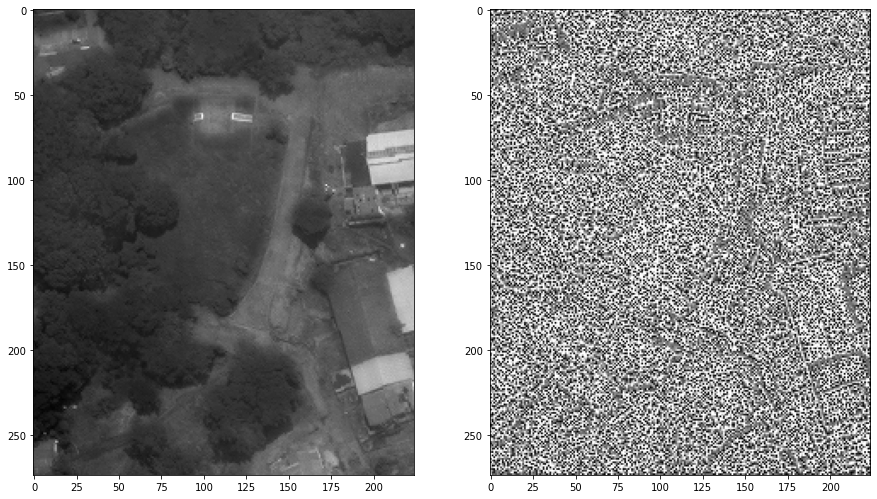

In [ ]:
plt.figure(figsize=(15, 12))
plt.subplot(121), plt.imshow(image[750:, 800:], cmap='gray')
plt.subplot(122), plt.imshow(lbp[750:, 800:], cmap='gray')
plt.show()